In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
%config InlineBackend.figure_formats = ['svg']

In [3]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FreeSans']
import seaborn as sns

In [4]:
save_dir = '../data/'
df_raw = pd.read_csv(os.path.join(save_dir, 'sepsis_final_data_RAW_withTimes.csv'))
df_data = pd.read_csv(os.path.join(save_dir, 'sepsis_final_data_withTimes.csv'))

In [5]:
df_raw.head()

,traj,step,m:presumed_onset,m:charttime,m:icustayid,o:gender,o:mechvent,o:max_dose_vaso,o:re_admission,o:age,...,o:SGOT,o:SGPT,o:Total_bili,o:INR,o:input_total,o:input_4hourly,o:output_total,o:output_4hourly,a:action,r:reward
0,1,0,7.245590e+09,7.245486e+09,200003.0,0.0,0.0,0.0,0.0,17639.826435,...,66.0,44.0,0.5,1.3,6527.0,50.0,13617.0,520.0,10,0.0
1,1,1,7.245590e+09,7.245500e+09,200003.0,0.0,0.0,0.0,0.0,17639.826435,...,38.0,30.0,5.2,1.0,6577.0,50.0,13982.0,365.0,10,0.0
2,1,2,7.245590e+09,7.245515e+09,200003.0,0.0,0.0,0.0,0.0,17639.826435,...,38.0,30.0,5.2,1.0,6627.0,50.0,14262.0,280.0,10,0.0
3,1,3,7.245590e+09,7.245529e+09,200003.0,0.0,0.0,0.0,0.0,17639.826435,...,38.0,30.0,5.2,1.3,6677.0,50.0,14602.0,340.0,10,0.0
4,1,4,7.245590e+09,7.245544e+09,200003.0,0.0,0.0,0.0,0.0,17639.826435,...,38.0,30.0,5.2,1.3,6727.0,50.0,15142.0,540.0,10,0.0


In [6]:
interventions = df_raw[['o:max_dose_vaso', 'o:input_4hourly']].copy()

In [7]:
# only compute quartiles on nonzero values
adjusted_vaso = interventions["o:max_dose_vaso"][interventions["o:max_dose_vaso"] > 0]
adjusted_iv = interventions["o:input_4hourly"][interventions["o:input_4hourly"] > 0]

In [8]:
vaso_quartiles = adjusted_vaso.quantile([0.25, 0.50, 0.75])
iv_quartiles = adjusted_iv.quantile([0.25, 0.5, 0.75])

In [9]:
vpq = np.array(vaso_quartiles)
ivq = np.array(iv_quartiles)
print('Vasopressor bins', vpq)
print('old IV fluids bins', ivq)

Vasopressor bins [0.08 0.2  0.45]
old IV fluids bins [ 50.         151.96329167 500.        ]


In [10]:
newivq  = np.array([500, 1000, 2000]) # change fluids range to be more clinically relevant
print('new IV fluids bins', newivq)

new IV fluids bins [ 500 1000 2000]


In [11]:
interventions['a:vaso'] = np.array(0, dtype=int)
interventions.loc[(interventions['o:max_dose_vaso'] == 0.0   ), 'a:vaso'] = 0
interventions.loc[(interventions['o:max_dose_vaso'] >  0.0   ) & (interventions['o:max_dose_vaso'] < vpq[0]), 'a:vaso'] = 1
interventions.loc[(interventions['o:max_dose_vaso'] >= vpq[0]) & (interventions['o:max_dose_vaso'] < vpq[1]), 'a:vaso'] = 2
interventions.loc[(interventions['o:max_dose_vaso'] >= vpq[1]) & (interventions['o:max_dose_vaso'] < vpq[2]), 'a:vaso'] = 3
interventions.loc[(interventions['o:max_dose_vaso'] >= vpq[2]), 'a:vaso'] = 4

In [12]:
interventions['a:iv_OLD'] = np.array(0, dtype=int)
interventions.loc[(interventions['o:input_4hourly'] == 0.0  ), 'a:iv_OLD'] = 0
interventions.loc[(interventions['o:input_4hourly'] >  0.0  )  & (interventions['o:input_4hourly'] < ivq[0]), 'a:iv_OLD'] = 1
interventions.loc[(interventions['o:input_4hourly'] >= ivq[0]) & (interventions['o:input_4hourly'] < ivq[1]), 'a:iv_OLD'] = 2
interventions.loc[(interventions['o:input_4hourly'] >= ivq[1]) & (interventions['o:input_4hourly'] < ivq[2]), 'a:iv_OLD'] = 3
interventions.loc[(interventions['o:input_4hourly'] >= ivq[2]), 'a:iv_OLD'] = 4

In [13]:
interventions['a:iv'] = np.array(0, dtype=int)
interventions.loc[(interventions['o:input_4hourly'] == 0.0      ), 'a:iv'] = 0
interventions.loc[(interventions['o:input_4hourly'] >  0.0      ) & (interventions['o:input_4hourly'] < newivq[0]), 'a:iv'] = 1
interventions.loc[(interventions['o:input_4hourly'] >= newivq[0]) & (interventions['o:input_4hourly'] < newivq[1]), 'a:iv'] = 2
interventions.loc[(interventions['o:input_4hourly'] >= newivq[1]) & (interventions['o:input_4hourly'] < newivq[2]), 'a:iv'] = 3
interventions.loc[(interventions['o:input_4hourly'] >= newivq[2]), 'a:iv'] = 4

In [14]:
interventions['a:action_OLD'] = interventions['a:iv_OLD']*5 + interventions['a:vaso']
interventions['a:action'] = interventions['a:iv']*5 + interventions['a:vaso']

In [15]:
interventions

,o:max_dose_vaso,o:input_4hourly,a:vaso,a:iv_OLD,a:iv,a:action_OLD,a:action
0,0.0,50.0,0,2,1,10,5
1,0.0,50.0,0,2,1,10,5
2,0.0,50.0,0,2,1,10,5
3,0.0,50.0,0,2,1,10,5
4,0.0,50.0,0,2,1,10,5
...,...,...,...,...,...,...,...
256568,0.0,0.0,0,0,0,0,0
256569,0.0,0.0,0,0,0,0,0
256570,0.0,0.0,0,0,0,0,0
256571,0.0,0.0,0,0,0,0,0


In [16]:
(interventions['a:action_OLD'] == df_raw['a:action']).mean()

0.9999805123687995

In [17]:
newdf_raw = pd.concat([df_raw.drop(columns=['a:action', 'o:max_dose_vaso', 'o:input_4hourly']), interventions], axis=1)
newdf_data = pd.concat([df_data.drop(columns=['a:action', 'o:max_dose_vaso', 'o:input_4hourly']), interventions], axis=1)

In [18]:
newdf_raw.to_csv(os.path.join(save_dir, 'sepsis_final_data_RAW_withTimes_newActions.csv'), index=False)
newdf_data.to_csv(os.path.join(save_dir, 'sepsis_final_data_withTimes_newActions.csv'), index=False)

### Visualize

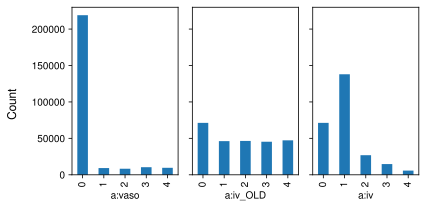

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(6,3), sharey=True)
interventions['a:vaso'].value_counts()[[0,1,2,3,4]].plot(kind='bar', ax=axes[0], xlabel='a:vaso')
interventions['a:iv_OLD'].value_counts()[[0,1,2,3,4]].plot(kind='bar', ax=axes[1], xlabel='a:iv_OLD')
interventions['a:iv'].value_counts()[[0,1,2,3,4]].plot(kind='bar', ax=axes[2], xlabel='a:iv')
fig.supylabel('Count')
plt.tight_layout()
plt.show()

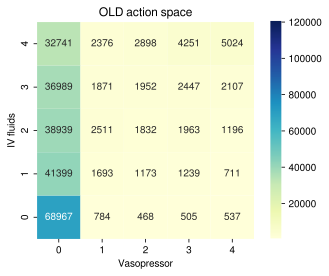

In [20]:
fig, ax = plt.subplots()
sns.heatmap(interventions['a:action_OLD'].value_counts().sort_index().values.reshape((5,5)), ax=ax, square=True, cmap="YlGnBu", vmax=1.2e5, annot=True, fmt='d')
ax.invert_yaxis()
plt.title('OLD action space')
plt.xlabel('Vasopressor')
plt.ylabel('IV fluids')
plt.show()

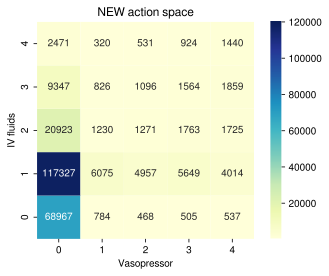

In [21]:
fig, ax = plt.subplots()
sns.heatmap(interventions['a:action'].value_counts().sort_index().values.reshape((5,5)), ax=ax, square=True, cmap="YlGnBu", vmax=1.2e5, annot=True, fmt='d')
ax.invert_yaxis()
plt.title('NEW action space')
plt.xlabel('Vasopressor')
plt.ylabel('IV fluids')
plt.show()